# Connect Forest Management Model with Forest Carbon Budget Model (without calibration)

## Set up Modelling Environment

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
import ws3.forest
import time
import gurobipy as grb
from util_opt import compile_scenario_maxstock, plot_scenario_maxstock, run_cbm_maxstock, cbm_report, plugin_c_curves, compare_ws3_cbm, compile_events
import pickle
# Import Module
from util_opt import compile_scenario_maxstock, plot_scenario_maxstock, run_cbm_maxstock
import libcbm

## Create and Run `ForestModel` instance

In [2]:
base_year = 2020
horizon = 10
period_length = 10
max_age = 1000
n_steps = 100
tvy_name = 'totvol'
case_study = 'equitysilver'

In [3]:
fm = ws3.forest.ForestModel(model_name='equitysilver',
                            # model_path='./data/woodstock_model_files_redchris_test',
                            model_path='./data/woodstock_model_files_equitysilver',
                            base_year=base_year,
                            horizon=horizon,
                            period_length=period_length,
                            max_age=max_age)
fm.import_landscape_section()
fm.import_areas_section()
fm.import_yields_section()
fm.import_actions_section()
fm.import_transitions_section()
fm.initialize_areas()
fm.add_null_action()
fm.reset_actions()

fm.grow()

In [4]:
# Flag 'harvest' as a harvesting action in the ws3 model
harvest_acode='harvest'
fm.actions[harvest_acode].is_harvest = True

(<Figure size 2000x500 with 4 Axes>,
 array([<Axes: title={'center': 'Harvested area'}, xlabel='Period', ylabel='Area (ha)'>,
        <Axes: title={'center': 'Harvested volume'}, xlabel='Period', ylabel='Volume (m3)'>,
        <Axes: title={'center': 'Growing Stock'}, xlabel='Period', ylabel='Volume (m3)'>,
        <Axes: title={'center': 'Ecosystem C stock'}, xlabel='Period', ylabel='Stock (ton)'>],
       dtype=object))

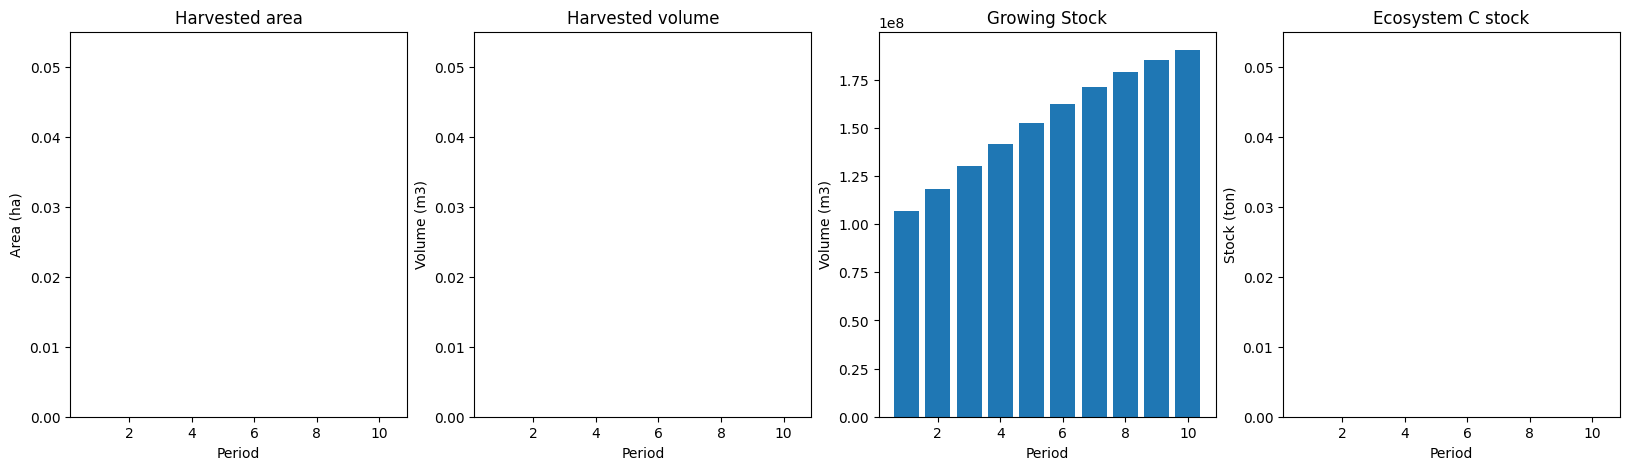

In [5]:
# Check the Forest Inventory of the Forest Model
df = compile_scenario_maxstock(fm)
plot_scenario_maxstock(df)

## Hard-link `ForestModel` to `libcbm`

Prepare CBM input files

In [6]:
# Define Disturance Types
disturbance_type_mapping = [{'user_dist_type': 'harvest', 'default_dist_type': 'Clearcut harvesting without salvage'},
                            {'user_dist_type': 'fire', 'default_dist_type': 'Wildfire'}]
for dtype_key in fm.dtypes:
    fm.dt(dtype_key).last_pass_disturbance = 'fire' if dtype_key[2] == dtype_key[4] else 'harvest'

In [7]:
sit_config, sit_tables = fm.to_cbm_sit(softwood_volume_yname='swdvol', 
                                       hardwood_volume_yname='hwdvol', 
                                       admin_boundary='British Columbia', 
                                       eco_boundary='Montane Cordillera',
                                       disturbance_type_mapping=disturbance_type_mapping)

Here are other two ways to generate sit tables. But they are only suitbale for small forest model since they take too much running time and memory

In [8]:
# Define Time Steps
n_steps = fm.horizon * fm.period_length

# Run CBM and Generate CBM 0utputs
cbm_output = run_cbm_maxstock(sit_config, sit_tables, n_steps)

Emissions from all biomass components only resulting from fire disturbance, while these from all DOM pools resulting from annual decay processes and fire disturbance.

In [9]:
# Define Carbon Pools
biomass_pools = ['SoftwoodMerch','SoftwoodFoliage', 'SoftwoodOther', 'SoftwoodCoarseRoots','SoftwoodFineRoots',                        
                 'HardwoodMerch', 'HardwoodFoliage', 'HardwoodOther', 'HardwoodCoarseRoots', 'HardwoodFineRoots']
dom_pools = ['AboveGroundVeryFastSoil', 'BelowGroundVeryFastSoil', 'AboveGroundFastSoil', 'BelowGroundFastSoil',
             'MediumSoil', 'AboveGroundSlowSoil', 'BelowGroundSlowSoil', 'SoftwoodStemSnag', 'SoftwoodBranchSnag',
             'HardwoodStemSnag', 'HardwoodBranchSnag']
emissions_pools = ['CO2', 'CH4', 'CO', 'NO2']
products_pools = ['Products']
ecosystem_pools = biomass_pools + dom_pools
all_pools = biomass_pools + dom_pools + emissions_pools + products_pools

In [10]:
# Define Carbon Fluxes
annual_process_fluxes = [
    'DecayDOMCO2Emission',
    'DeltaBiomass_AG',
    'DeltaBiomass_BG',
    'TurnoverMerchLitterInput',
    'TurnoverFolLitterInput',
    'TurnoverOthLitterInput',
    'TurnoverCoarseLitterInput',
    'TurnoverFineLitterInput',
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir'
]

npp_fluxes=[
    'DeltaBiomass_AG', 
    'DeltaBiomass_BG'
]
decay_emissions_fluxes = [
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir'
]

disturbance_production_fluxes = [
    'DisturbanceSoftProduction',
    'DisturbanceHardProduction',
    'DisturbanceDOMProduction'   
]

disturbance_emissions_fluxes = [
    'DisturbanceMerchToAir',
    'DisturbanceFolToAir',
    'DisturbanceOthToAir',
    'DisturbanceCoarseToAir',
    'DisturbanceFineToAir',
    'DisturbanceVFastAGToAir',
    'DisturbanceVFastBGToAir',
    'DisturbanceFastAGToAir',
    'DisturbanceFastBGToAir',
    'DisturbanceMediumToAir',
    'DisturbanceSlowAGToAir',
    'DisturbanceSlowBGToAir',
    'DisturbanceSWStemSnagToAir',
    'DisturbanceSWBranchSnagToAir',
    'DisturbanceHWStemSnagToAir',
    'DisturbanceHWBranchSnagToAir'   
]

all_fluxes = [
    'DisturbanceCO2Production',
    'DisturbanceCH4Production',
    'DisturbanceCOProduction',
    'DisturbanceBioCO2Emission',
    'DisturbanceBioCH4Emission',
    'DisturbanceBioCOEmission',
    'DecayDOMCO2Emission',
    'DisturbanceSoftProduction',
    'DisturbanceHardProduction',
    'DisturbanceDOMProduction',
    'DeltaBiomass_AG',
    'DeltaBiomass_BG',
    'TurnoverMerchLitterInput',
    'TurnoverFolLitterInput',
    'TurnoverOthLitterInput',
    'TurnoverCoarseLitterInput',
    'TurnoverFineLitterInput',
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir',
    'DisturbanceMerchToAir',
    'DisturbanceFolToAir',
    'DisturbanceOthToAir',
    'DisturbanceCoarseToAir',
    'DisturbanceFineToAir',
    'DisturbanceDOMCO2Emission',
    'DisturbanceDOMCH4Emission',
    'DisturbanceDOMCOEmission',
    'DisturbanceMerchLitterInput',
    'DisturbanceFolLitterInput',
    'DisturbanceOthLitterInput',
    'DisturbanceCoarseLitterInput',
    'DisturbanceFineLitterInput',
    'DisturbanceVFastAGToAir',
    'DisturbanceVFastBGToAir',
    'DisturbanceFastAGToAir',
    'DisturbanceFastBGToAir',
    'DisturbanceMediumToAir',
    'DisturbanceSlowAGToAir',
    'DisturbanceSlowBGToAir',
    'DisturbanceSWStemSnagToAir',
    'DisturbanceSWBranchSnagToAir',
    'DisturbanceHWStemSnagToAir',
    'DisturbanceHWBranchSnagToAir'
]

grossgrowth_ag = [
    "DeltaBiomass_AG",
    "TurnoverMerchLitterInput",
    "TurnoverFolLitterInput",
    "TurnoverOthLitterInput",
]

grossgrowth_bg = [
    "DeltaBiomass_BG",
    "TurnoverCoarseLitterInput",
    "TurnoverFineLitterInput",
]

product_flux = [
     "DisturbanceSoftProduction",
     "DisturbanceHardProduction",
     "DisturbanceDOMProduction",
]

GrossGrowth_AG = flux[[
        "DeltaBiomass_AG",
        "TurnoverMerchLitterInput",
        "TurnoverFolLitterInput",
        "TurnoverOthLitterInput",
        ]].sum(axis=1)

GrossGrowth_BG = flux[[
        "DeltaBiomass_BG",
        "TurnoverCoarseLitterInput",
        "TurnoverFineLitterInput",
        ]].sum(axis=1)

In [11]:
# Define Sum Carbon Pools and Sum Carbon Fluxes
pools = ecosystem_pools
fluxes = decay_emissions_fluxes + disturbance_emissions_fluxes
gross_growth = grossgrowth_ag + grossgrowth_bg

sum_pools = ['ecosystem', 'biomass', 'DOM']

,Biomass,DOM,Ecosystem,All_Emissions,Gross_Growth,Stock_Change
Year,,,,,,
0,5.822073e+07,1.222542e+08,1.804750e+08,0.000000e+00,0.000000e+00,0.000000
1,5.871998e+07,1.221095e+08,1.808295e+08,2.698916e+06,3.053426e+06,-354510.028018
2,5.921411e+07,1.219807e+08,1.811948e+08,2.699385e+06,3.064685e+06,-365300.196877
3,5.970696e+07,1.218664e+08,1.815734e+08,2.700477e+06,3.079076e+06,-378598.301206
4,6.020047e+07,1.217660e+08,1.819664e+08,2.702128e+06,3.095212e+06,-393083.488615
...,...,...,...,...,...,...
96,8.888489e+07,1.328625e+08,2.217474e+08,3.118794e+06,3.422864e+06,-304069.939522
97,8.900069e+07,1.330478e+08,2.220485e+08,3.121645e+06,3.422719e+06,-301073.773681
98,8.910958e+07,1.332344e+08,2.223440e+08,3.124494e+06,3.420029e+06,-295534.434088


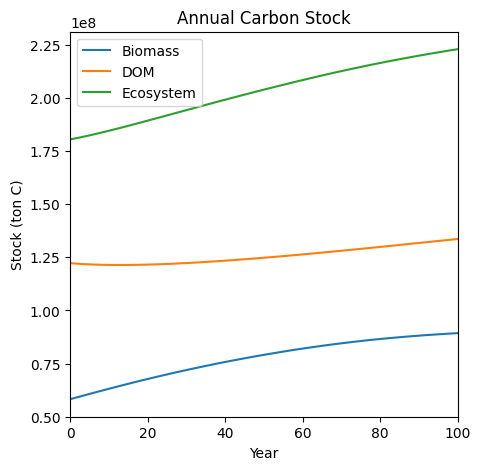

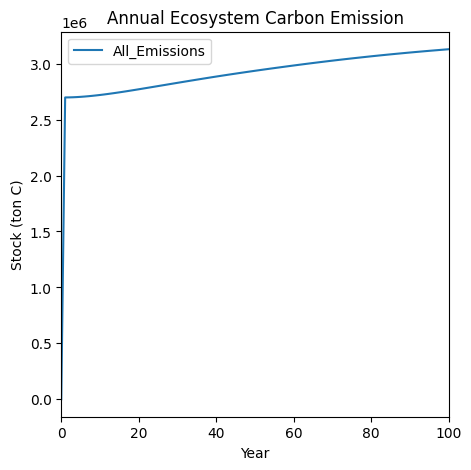

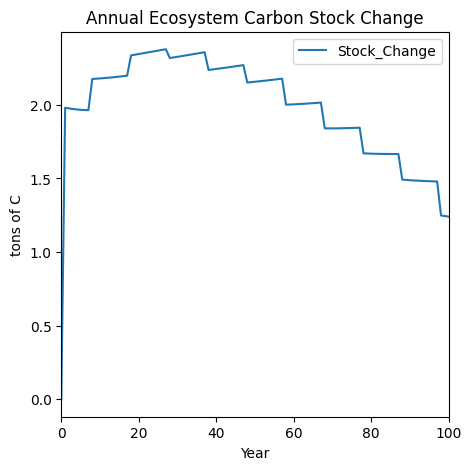

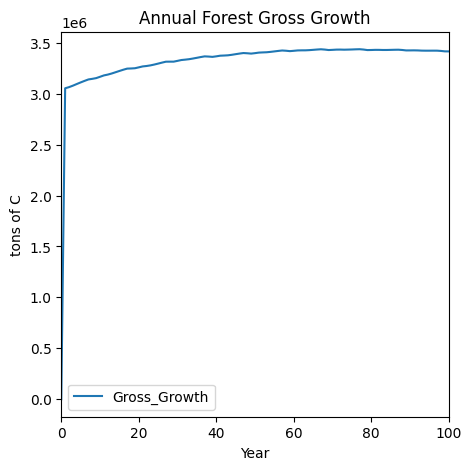

In [12]:
# Report Annual CBM Results
cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes, gross_growth)

## Plug-in Carbon Yield Curves

In [13]:
# Read curves
c_curves_p = pd.read_pickle("./equitysilver_c_curves_p.pkl")
# c_curves_p = pd.read_pickle("./redchris_c_curves_p_exactmatch.pkl")
# c_curves_f = pd.read_pickle("redchris_c_curves_f.pkl") # Not created yet

In [14]:
# Plug carbon yield curves into forest model
plugin_c_curves(fm, c_curves_p, pools=sum_pools)
# plugin_c_curves(fm, c_curves_p, c_curves_f, pools=sum_pools, fluxes=['net_fluxes', 'total_emissions'])

found match for mask ('?', '?', '?', '?', '1', '1')
found match for mask ('?', '?', '?', '?', '2', '2')
found match for mask ('?', '?', '?', '?', '3', '3')
found match for mask ('?', '?', '?', '?', '4', '4')
found match for mask ('?', '?', '?', '?', '5', '5')
found match for mask ('?', '?', '?', '?', '6', '6')
found match for mask ('?', '?', '?', '?', '7', '7')
found match for mask ('?', '?', '?', '?', '8', '8')
found match for mask ('?', '?', '?', '?', '9', '9')
found match for mask ('?', '?', '?', '?', '10', '10')
found match for mask ('?', '?', '?', '?', '11', '11')
found match for mask ('?', '?', '?', '?', '12', '12')
found match for mask ('?', '?', '?', '?', '13', '13')
found match for mask ('?', '?', '?', '?', '14', '14')
found match for mask ('?', '?', '?', '?', '15', '15')
found match for mask ('?', '?', '?', '?', '16', '16')
found match for mask ('?', '?', '?', '?', '17', '17')
found match for mask ('?', '?', '?', '?', '18', '18')
found match for mask ('?', '?', '?', '?', '19'

In [26]:
# Check if all carbon yield curves are plugged in well.
fm.yields

[(('?', '?', '?', '?', '?', '?'), '', []),
 (('?', '?', '?', '?', '12', '12'),
  'a',
  [('s1201', <ws3.core.Curve at 0x7fc85d587c70>),
   ('ecosystem', <ws3.core.Curve at 0x7fc83d3d84f0>),
   ('biomass', <ws3.core.Curve at 0x7fc83d3d91e0>),
   ('DOM', <ws3.core.Curve at 0x7fc83d3d86a0>),
   ('ecosystem', <ws3.core.Curve at 0x7fc83d3d84f0>),
   ('biomass', <ws3.core.Curve at 0x7fc83d3d91e0>),
   ('DOM', <ws3.core.Curve at 0x7fc83d3d86a0>),
   ('ecosystem', <ws3.core.Curve at 0x7fc83d3d84f0>),
   ('biomass', <ws3.core.Curve at 0x7fc83d3d91e0>),
   ('DOM', <ws3.core.Curve at 0x7fc83d3d86a0>),
   ('ecosystem', <ws3.core.Curve at 0x7fc83d3d84f0>),
   ('biomass', <ws3.core.Curve at 0x7fc83d3d91e0>),
   ('DOM', <ws3.core.Curve at 0x7fc83d3d86a0>),
   ('ecosystem', <ws3.core.Curve at 0x7fc83d3d84f0>),
   ('biomass', <ws3.core.Curve at 0x7fc83d3d91e0>),
   ('DOM', <ws3.core.Curve at 0x7fc83d3d86a0>),
   ('ecosystem', <ws3.core.Curve at 0x7fc83d3d84f0>),
   ('biomass', <ws3.core.Curve at 0x7fc8

(<Figure size 2000x500 with 4 Axes>,
 array([<Axes: title={'center': 'Harvested area'}, xlabel='Period', ylabel='Area (ha)'>,
        <Axes: title={'center': 'Harvested volume'}, xlabel='Period', ylabel='Volume (m3)'>,
        <Axes: title={'center': 'Growing Stock'}, xlabel='Period', ylabel='Volume (m3)'>,
        <Axes: title={'center': 'Ecosystem C stock'}, xlabel='Period', ylabel='Stock (ton)'>],
       dtype=object))

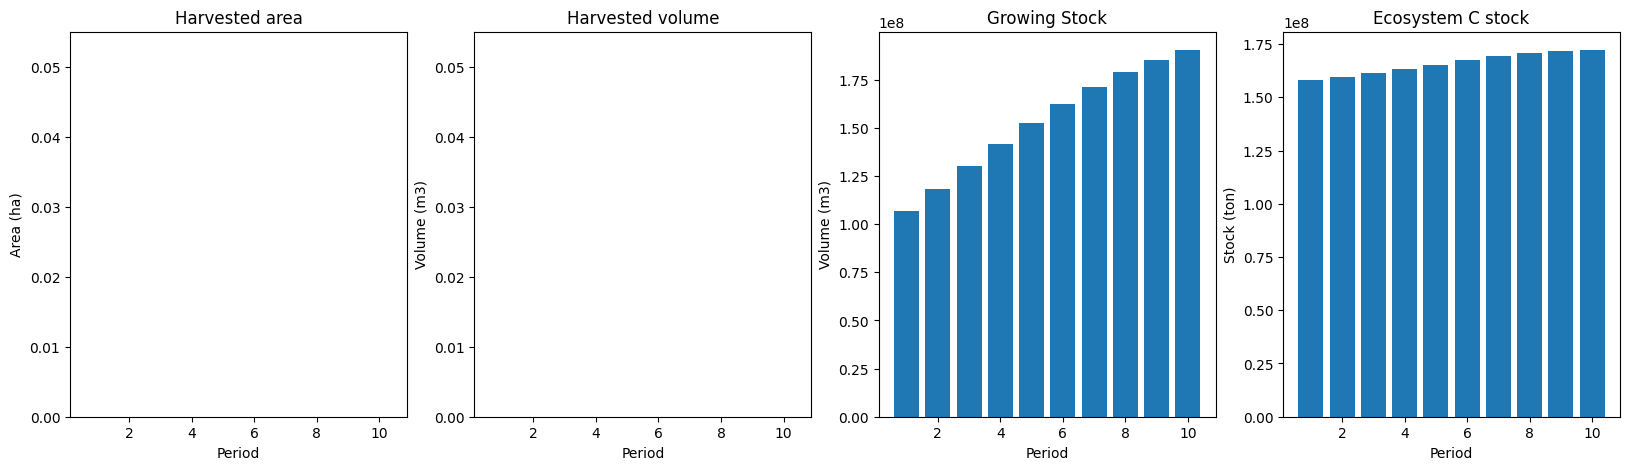

In [16]:
# Check the Forest Inventory of the ws3 Model without harvesting
df = compile_scenario_maxstock(fm)
plot_scenario_maxstock(df)

## No-harvest

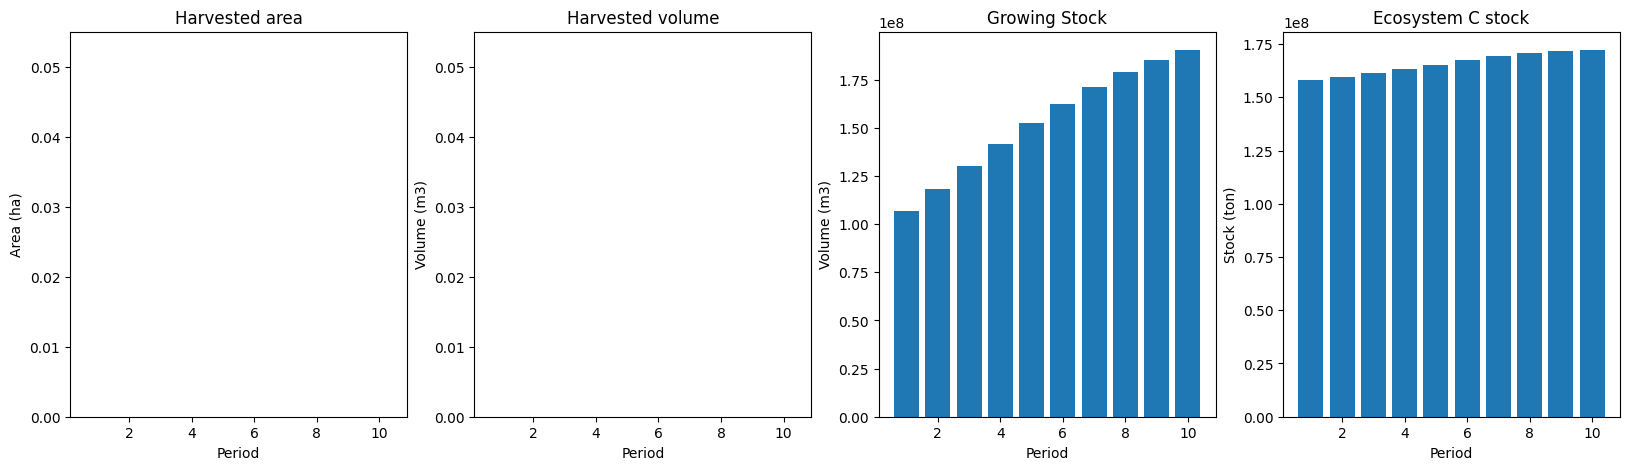

In [17]:
df = compile_scenario_maxstock(fm)
fig, ax = plot_scenario_maxstock(df)

In [18]:
#Define Basic Variables
softwood_volume_yname='swdvol' 
hardwood_volume_yname='hwdvol'
n_yield_vals=100

In [19]:
#Generate New Sit_events file
sit_events = compile_events(fm, softwood_volume_yname, hardwood_volume_yname, n_yield_vals)

In [20]:
# Replace the Sit_events file in the sit tables
sit_tables['sit_events'] = sit_events

In [21]:
sit_events

,theme0,theme1,theme2,theme3,theme4,theme5,species,using_age_class,min_softwood_age,max_softwood_age,...,MinSWMerchStemSnagC,MaxSWMerchStemSnagC,MinHWMerchStemSnagC,MaxHWMerchStemSnagC,efficiency,sort_type,target_type,target,disturbance_type,disturbance_year


In [22]:
# Run CBM and Generate CBM Ouputs
cbm_output = run_cbm_maxstock(sit_config, sit_tables, n_steps)

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


,Biomass,DOM,Ecosystem,All_Emissions,Gross_Growth,Stock_Change
Year,,,,,,
0,5.822073e+07,1.222542e+08,1.804750e+08,0.000000e+00,0.000000e+00,0.000000
1,5.871998e+07,1.221095e+08,1.808295e+08,2.698916e+06,3.053426e+06,-354510.028018
2,5.921411e+07,1.219807e+08,1.811948e+08,2.699385e+06,3.064685e+06,-365300.196877
3,5.970696e+07,1.218664e+08,1.815734e+08,2.700477e+06,3.079076e+06,-378598.301206
4,6.020047e+07,1.217660e+08,1.819664e+08,2.702128e+06,3.095212e+06,-393083.488615
...,...,...,...,...,...,...
96,8.888489e+07,1.328625e+08,2.217474e+08,3.118794e+06,3.422864e+06,-304069.939522
97,8.900069e+07,1.330478e+08,2.220485e+08,3.121645e+06,3.422719e+06,-301073.773681
98,8.910958e+07,1.332344e+08,2.223440e+08,3.124494e+06,3.420029e+06,-295534.434088


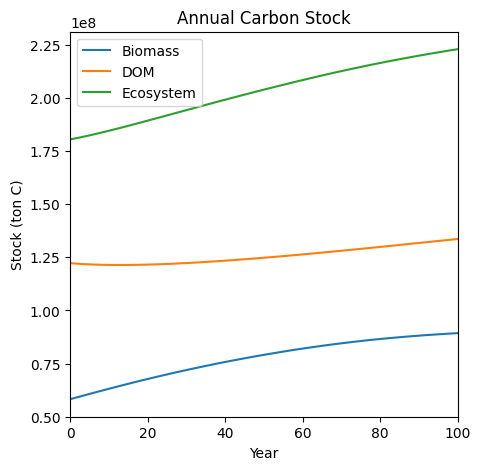

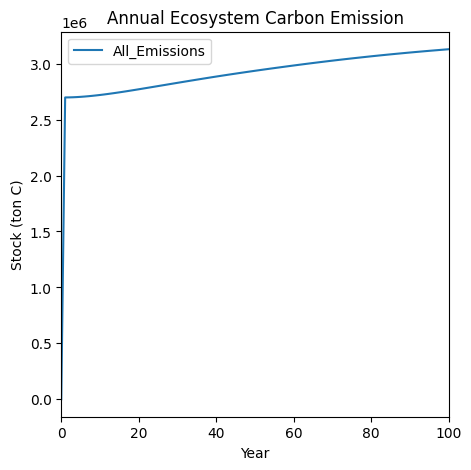

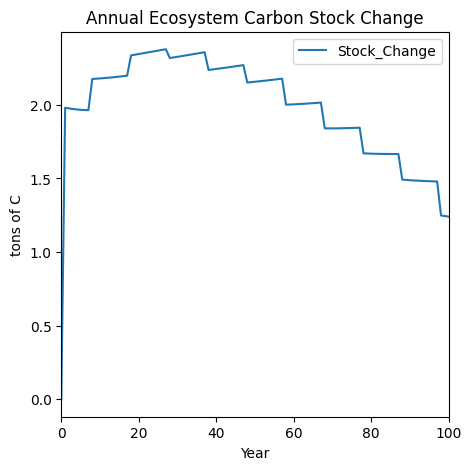

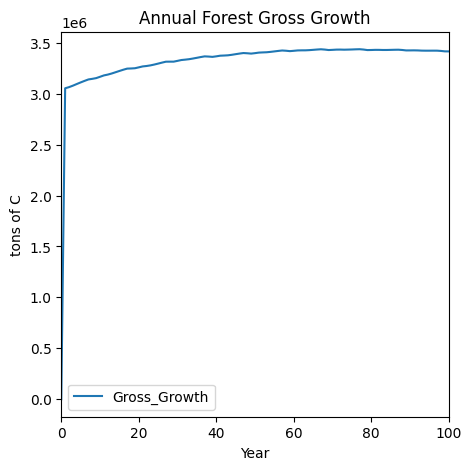

In [23]:
# Report Annual CBM Outputs
cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes, gross_growth)

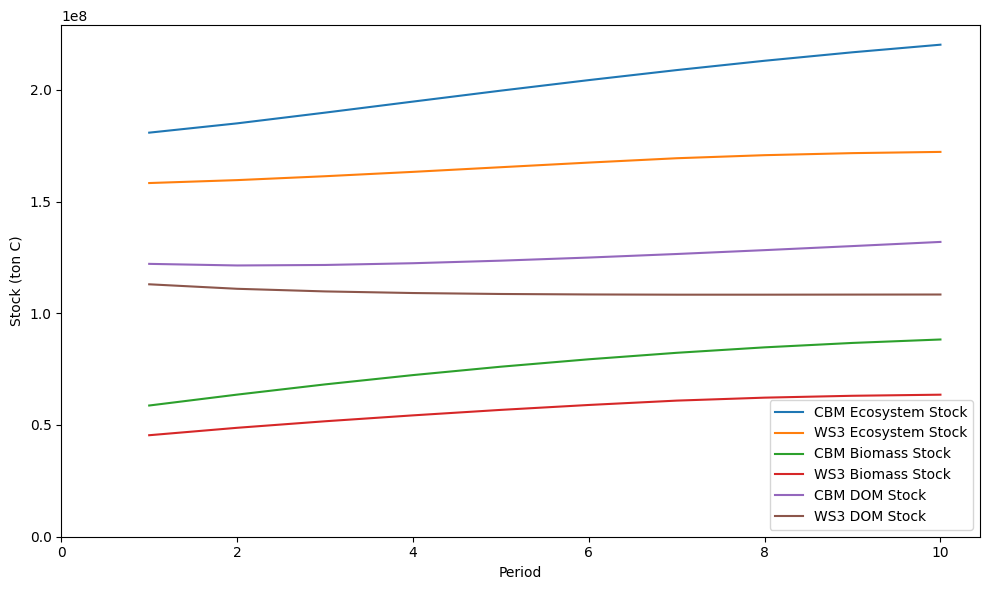

(   period  biomass_stock     dom_stock     eco_stock  eco_stock_change
 0       1   5.871998e+07  1.221095e+08  1.808295e+08      0.000000e+00
 1       2   6.359534e+07  1.213954e+08  1.849907e+08      4.161254e+06
 2       3   6.817118e+07  1.216164e+08  1.897876e+08      4.796894e+06
 3       4   7.233254e+07  1.223969e+08  1.947294e+08      4.941794e+06
 4       5   7.608993e+07  1.235419e+08  1.996318e+08      4.902389e+06
 5       6   7.940788e+07  1.249374e+08  2.043453e+08      4.713487e+06
 6       7   8.230760e+07  1.265239e+08  2.088315e+08      4.486252e+06
 7       8   8.475152e+07  1.282544e+08  2.130059e+08      4.174334e+06
 8       9   8.672844e+07  1.300697e+08  2.167982e+08      3.792303e+06
 9      10   8.826551e+07  1.319300e+08  2.201955e+08      3.397339e+06,
    period  biomass_stock     dom_stock     eco_stock  eco_stock_change
 0       1   4.542270e+07  1.129676e+08  1.582811e+08      0.000000e+00
 1       2   4.874701e+07  1.109550e+08  1.595903e+08      1.30

In [24]:
# Compare the carbon outputs from ws3 (table above) and libcbm (table below)
compare_ws3_cbm(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, plots='whole')

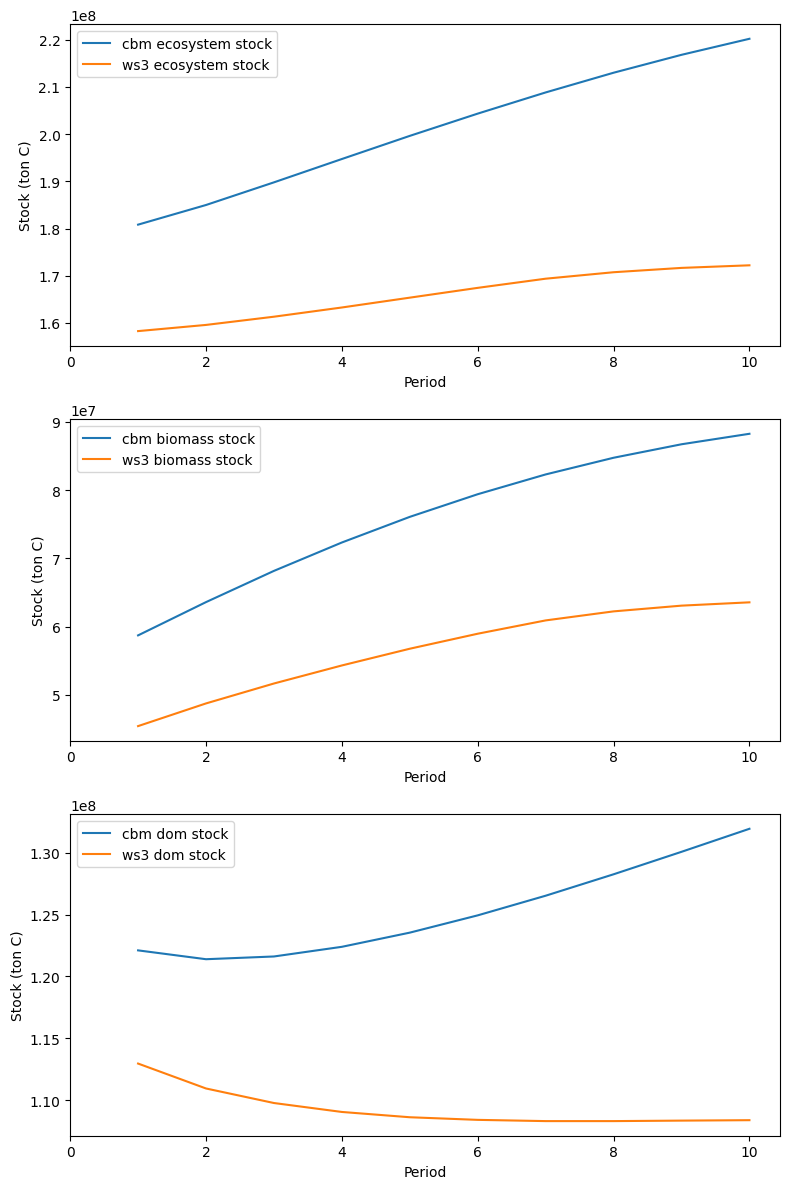

(   period  biomass_stock     dom_stock     eco_stock  eco_stock_change
 0       1   5.871998e+07  1.221095e+08  1.808295e+08      0.000000e+00
 1       2   6.359534e+07  1.213954e+08  1.849907e+08      4.161254e+06
 2       3   6.817118e+07  1.216164e+08  1.897876e+08      4.796894e+06
 3       4   7.233254e+07  1.223969e+08  1.947294e+08      4.941794e+06
 4       5   7.608993e+07  1.235419e+08  1.996318e+08      4.902389e+06
 5       6   7.940788e+07  1.249374e+08  2.043453e+08      4.713487e+06
 6       7   8.230760e+07  1.265239e+08  2.088315e+08      4.486252e+06
 7       8   8.475152e+07  1.282544e+08  2.130059e+08      4.174334e+06
 8       9   8.672844e+07  1.300697e+08  2.167982e+08      3.792303e+06
 9      10   8.826551e+07  1.319300e+08  2.201955e+08      3.397339e+06,
    period  biomass_stock     dom_stock     eco_stock  eco_stock_change
 0       1   4.542270e+07  1.129676e+08  1.582811e+08      0.000000e+00
 1       2   4.874701e+07  1.109550e+08  1.595903e+08      1.30

In [25]:
# Compare the carbon outputs from ws3 (table above) and libcbm (table below)
compare_ws3_cbm(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, plots='individual')

## Maximize the Total System Carbon Stock

In [ ]:
#Define constants from product carbon estimation

# Define the product half-lives（>0.69)
half_life_solid_wood = 30
half_life_paper = 2

# Define the allocation distribution
proportion_solid_wood = 0.5

# Define the displacement factor 
displacement_factor = 2.2

In [ ]:
from util import cmp_c_ss, cmp_c_se, track_system_stock, track_system_emission, compare_ws3_cbm

In [ ]:
from util import cmp_c_z, cmp_c_cflw, cmp_c_caa, cmp_c_ci, cmp_c_i, cmp_c_id, gen_scenario, run_scenario

In [ ]:
#Install Module
%pip install gurobipy
#Import Module
import gurobipy as grb
#Add a Null Action
fm.add_null_action()

In [ ]:
# Maximize Harvest
run_scenario(fm,'base')

In [ ]:
df = compile_scenario(fm)
fig, ax = plot_scenario(df)

In [ ]:
#Import Module
from util import compile_events

In [ ]:
#Define Basic Variables
softwood_volume_yname='swdvol' 
hardwood_volume_yname='hwdvol'
n_yield_vals=100

In [ ]:
#Generate New Sit_events file
sit_events = compile_events(fm, softwood_volume_yname, hardwood_volume_yname, n_yield_vals)

In [ ]:
# Replace the Sit_events file in the sit tables
sit_tables['sit_events'] = sit_events

In [ ]:
sit_events

In [ ]:
# Run CBM and Generate CBM Ouputs
cbm_output = run_cbm(sit_config, sit_tables, n_steps)

In [ ]:
# Report Annual CBM Outputs
cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes, gross_growth)

In [ ]:
# Compare the carbon outputs from ws3 (table above) and libcbm (table below)
from util import compare_ws3_cbm
compare_ws3_cbm(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools)

In [ ]:
track_system_stock(fm, half_life_solid_wood, half_life_paper, proportion_solid_wood)

In [ ]:
track_system_emission(fm, half_life_solid_wood, half_life_paper, proportion_solid_wood, displacement_factor)